# Importing and Cleaning Data

In [924]:
#Load Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
import plotly.express as px
from collections import Counter
import collections
import math

In [925]:
#Load Raw Data
data = pd.read_csv('/Users/samgreene/pga_all_data3.csv')

In [926]:
#Load Par 5 Data
p5_data = pd.read_csv('/Users/samgreene/par5_data.csv')
p5_data = p5_data.drop(p5_data.columns[0], axis = 1)

In [927]:
#Load 2020 Masters players
players_2020 = pd.read_excel('/Users/samgreene/Downloads/2020Masters.xlsx')

In [928]:
#Data Cleaning
data = data.drop(data.columns[0], axis = 1)

def avg_y_x(row):
    if math.isnan(row['avg_y']) == True:
        row['avg_y'] = row['avg_x']
    return row['avg_y']

##Merge and clean par 5 data
data = pd.merge(data, p5_data, on = ['player_name', 'year'], how = 'left')

data['avg_y'] = data.apply(lambda row: avg_y_x(row), axis=1)

data = data.drop('avg_x', axis = 1)
data.rename(columns = {'avg_y': 'par5_sa'}, inplace = True)

##Separate 2020 and 2021 data
data2020 = data.loc[data['year'] == 2020]
data2021 = data.loc[data['year'] == 2021]
data = data.loc[data['year'] != 2020]
data = data.loc[data['year'] != 2021]

##Drop NAs
data = data.dropna()

##Clean up some of the variables
def rem_t(string):
    if type(string) == str:
        if string[0] == 'T':
            string = int(string[1:])
        else:
            string = string
    return string

data['masters_finish'] = data['masters_finish'].apply(rem_t)
data2020['masters_finish'] = data2020['masters_finish'].apply(rem_t)

def top_10(pos):
    if type(pos) == int:
        if pos <= 10:
            top_10 = 1
        else:
            top_10 = 0
    else:
        top_10 = 0
    return top_10

def str_int(x):
    if type(x) == str:  
        x = x.replace(",","")
        x = float(x)
    return x

data['hole_proximity'] = data['hole_proximity'].apply(str_int)
data['x_of_attempts'] = data['x_of_attempts'].apply(str_int)
data2020['hole_proximity'] = data2020['hole_proximity'].apply(str_int)
data2020['x_of_attempts'] = data2020['x_of_attempts'].apply(str_int)
data2021['hole_proximity'] = data2021['hole_proximity'].apply(str_int)
data2021['x_of_attempts'] = data2021['x_of_attempts'].apply(str_int)

data['prox'] = data.apply(lambda row: row.hole_proximity/row.x_of_attempts, axis=1)
data2020['prox'] = data2020.apply(lambda row: row.hole_proximity/row.x_of_attempts, axis=1)
data2021['prox'] = data2021.apply(lambda row: row.hole_proximity/row.x_of_attempts, axis=1)

data = data.drop('hole_proximity', axis = 1)
data = data.drop('x_of_attempts', axis = 1)

data['masters_t10'] = data['masters_finish'].apply(top_10)
data.loc[data['masters_finish'] == '1', 'masters_finish'] = 1
data.loc[data['masters_finish'] == 'Win', 'masters_finish'] = 1

##Keep only masters participants
data2020 = pd.merge(data2020, players_2020, left_on = 'player_name', right_on = 'player_names', how = 'inner')
data2021 = pd.merge(data2021, players_2020, left_on = 'player_name', right_on = 'player_names', how = 'inner')

data2020 = data2020.drop('player_names', axis = 1)
data2021 = data2021.drop('player_names', axis = 1)

data2021 = data2021.drop('masters_finish', axis = 1)
data2021 = data2021.dropna()

In [929]:
data2021

,year,player_name,ranking,top_10,wins,score_average,rounds,bounce_back,driving_accuracy,driving_distance,...,sg_putt,sg_t2g,sg_total,sg_approach,sg_tee,sg_ar,par4_sa,par3_sa,par5_sa,prox
0,2021,Abraham Ancer,80,1,0,70.610,20.0,20.00,69.93,293.4,...,0.162,0.379,0.541,-0.063,0.186,0.256,4.00,3.05,4.63,37.335674
1,2021,Adam Hadwin,145,0,0,71.618,18.0,20.34,62.50,295.7,...,-0.044,-0.165,-0.209,-0.643,-0.011,0.489,4.02,3.14,4.72,40.889860
2,2021,Adam Scott,100,0,0,70.072,12.0,27.08,48.17,312.0,...,0.638,0.110,0.748,0.338,-0.067,-0.162,4.14,2.98,4.83,41.761739
3,2021,Andrew Landry,148,0,0,72.990,16.0,23.21,67.89,295.3,...,-0.515,0.011,-0.505,0.078,-0.093,0.025,4.08,3.10,4.73,36.095431
4,2021,Andrew Putnam,182,0,0,71.131,21.0,16.33,54.11,287.6,...,0.580,-0.608,-0.029,0.075,-0.769,0.086,3.99,3.07,4.65,38.511419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2021,Tyler Duncan,T183,0,0,71.680,20.0,19.35,66.79,287.5,...,-0.331,0.175,-0.156,0.441,0.137,-0.403,4.08,3.10,4.69,40.262901
80,2021,Tyrrell Hatton,19,2,0,70.124,16.0,19.05,64.35,297.0,...,0.718,0.839,1.557,0.767,0.484,-0.412,3.94,3.04,4.73,30.972224
82,2021,Webb Simpson,28,2,0,69.406,16.0,29.73,72.73,293.5,...,0.754,1.026,1.780,-0.109,0.507,0.628,3.97,2.94,4.54,37.355741
83,2021,Xander Schauffele,7,2,0,69.135,16.0,19.05,52.27,303.7,...,1.074,1.567,2.641,0.625,0.249,0.694,3.99,2.97,4.47,39.171729


In [930]:
data

,year,player_name,ranking,top_10,wins,score_average,rounds,bounce_back,driving_accuracy,driving_distance,...,sg_total,sg_approach,sg_tee,sg_ar,par4_sa,par3_sa,masters_finish,par5_sa,prox,masters_t10
2,2007,Aaron Baddeley,T44,7,1,70.088,83.0,18.07,60.00,291.9,...,1.064,-0.252,0.152,0.535,4.08,3.08,52,4.56,37.225432,0
3,2008,Aaron Baddeley,34,3,0,70.196,76.0,20.20,59.45,290.3,...,0.885,-0.192,0.096,0.218,4.05,3.08,CUT,4.61,38.197664,0
4,2009,Aaron Baddeley,111,2,0,71.153,66.0,17.17,56.48,287.8,...,-0.151,-0.507,-0.459,0.212,4.08,3.09,17,4.67,37.376011,0
6,2011,Aaron Baddeley,24,5,1,70.230,77.0,26.15,55.67,296.2,...,1.148,0.196,0.190,0.438,4.00,3.10,47,4.59,37.401952,0
7,2012,Aaron Baddeley,108,3,0,71.113,73.0,18.97,54.30,292.0,...,0.143,-0.504,-0.108,0.152,4.08,3.13,40,4.65,38.258580,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3309,2014,Zach Johnson,26,5,1,70.159,97.0,20.25,70.51,282.2,...,0.857,0.513,0.145,0.093,4.03,3.03,CUT,4.58,33.369366,0
3310,2015,Zach Johnson,13,10,1,69.753,90.0,23.04,71.21,282.6,...,1.120,0.605,0.240,0.236,3.98,3.00,9,4.61,34.487072,1
3312,2017,Zach Johnson,72,4,0,70.393,81.0,16.75,67.53,286.9,...,0.631,-0.007,-0.005,0.226,4.01,3.06,CUT,4.75,34.993350,0
3313,2018,Zach Johnson,27,2,0,69.911,94.0,20.67,63.88,289.8,...,1.035,0.463,-0.059,0.425,3.98,3.01,36,4.63,33.894604,0


# Exploratory Analysis

Look at distribution of each predictor to check for skew

In [931]:
#Get predictor data
columns = list(data.columns.values)
predictors = columns[3:]
predictors.remove('masters_finish')
predictors.remove('masters_t10')
predictors.remove('rounds')
pred_data = data[predictors]

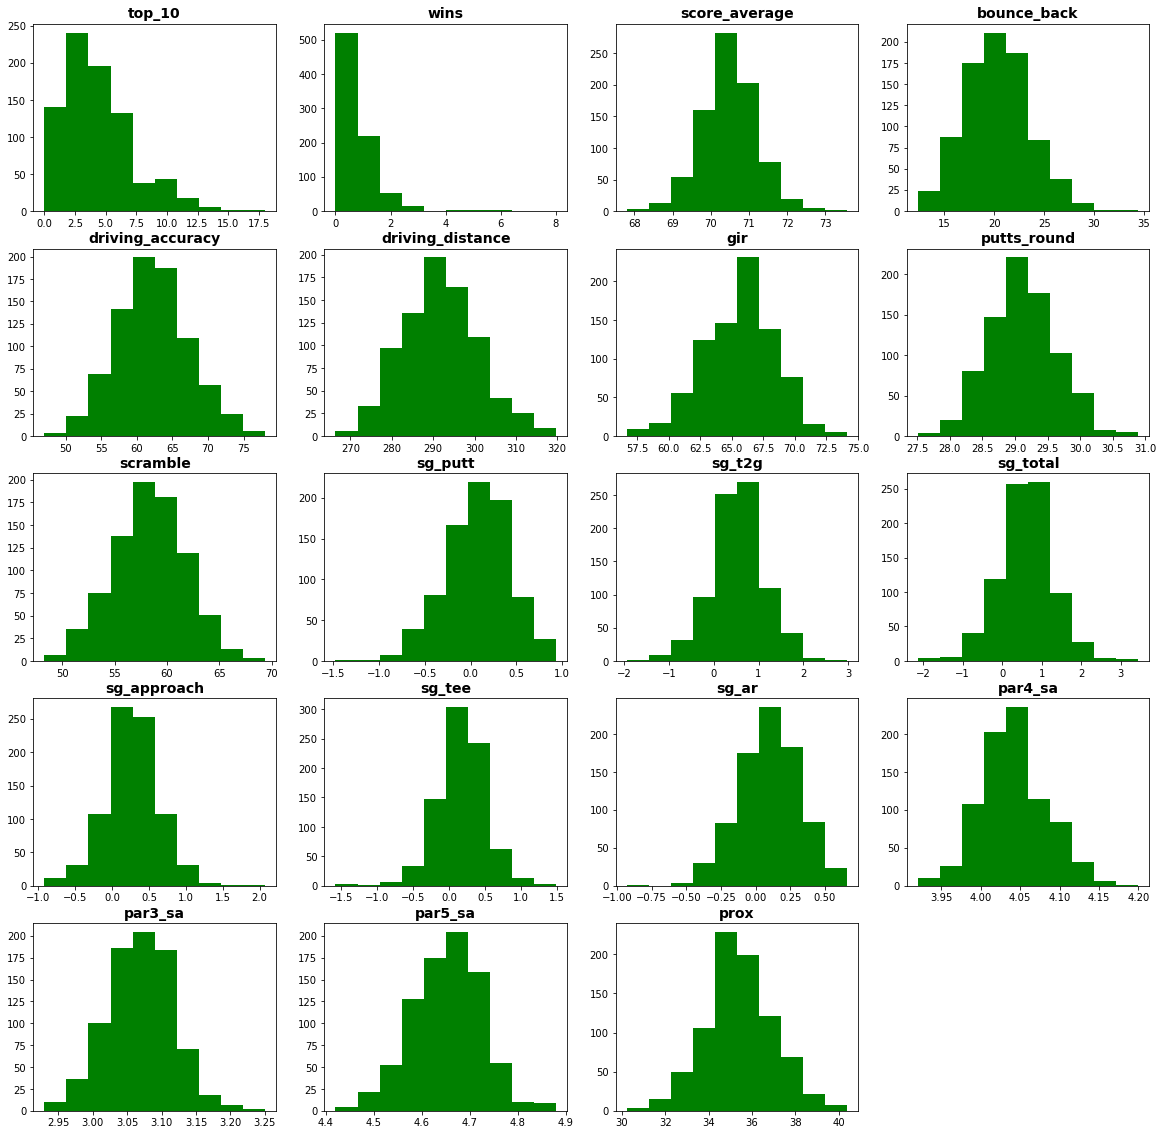

In [932]:
#Plot Histograms of potential predictors
plt.figure(figsize=(20,20))

for i in range(0, len(predictors)):
    plt.subplot(5,4,i+1)
    plt.gca().set_title(predictors[i], fontsize=14, fontweight='bold')
    plt.hist(pred_data.iloc[:,i], color = 'green')

plt.savefig('hist.png')

## Compare Masters Top10 Finishers to Others
The Masters is typically at the beginning of the PGA season, due to Covid-19 it was pushed back to November in 2020. Therefore, we have a much better idea of how the player is performing coming into the Masters this year. We can look at characteristics of Masters winners from the past based on their stats following the tournament in that season. This should help us understand what traits we want to look for in our 2020 winner

In [933]:
columns = list(data.columns.values)
predictors = columns[3:]
predictors.remove('rounds')
pred_data = data[predictors]
master_t10 = pred_data.loc[pred_data['masters_t10'] == 1]
master_winners = pred_data.loc[pred_data['masters_finish'] == 1]
rest = pred_data.loc[pred_data['masters_t10'] == 0]
rest = rest.drop('masters_t10', axis =1)
master_t10 = master_t10.drop('masters_t10', axis =1)
master_t10 = master_t10.drop('masters_finish', axis =1)
master_winners = master_winners.drop('masters_finish', axis = 1)
master_winners = master_winners.drop('masters_t10', axis = 1)
rest = rest.drop('masters_finish', axis = 1)
predictors.remove('masters_t10')
predictors.remove('masters_finish')

### Top 10 vs Rest

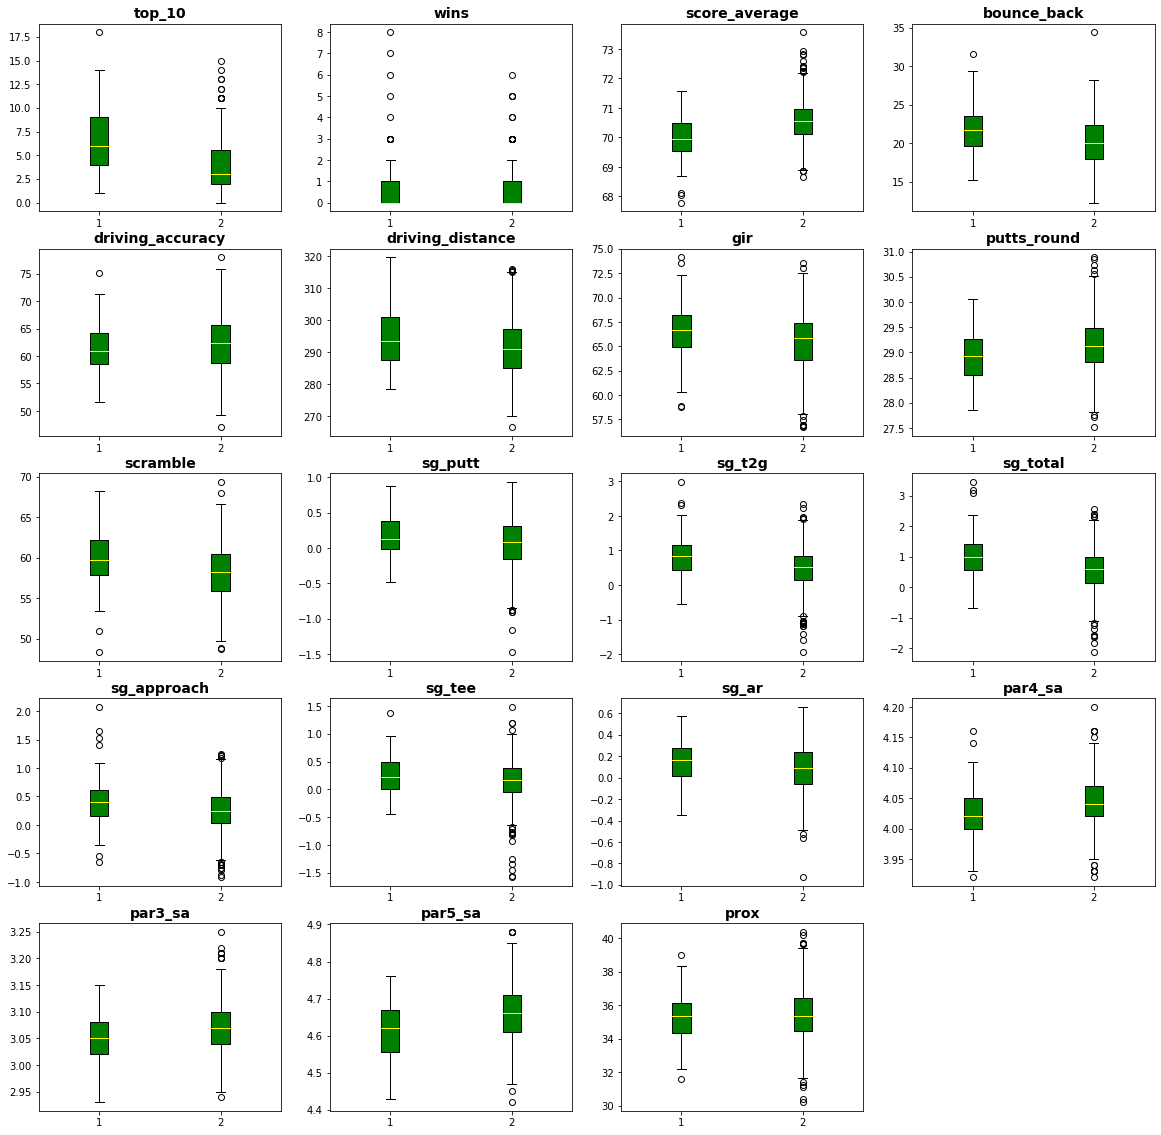

In [934]:
#Plot Boxplots of Top 10 finishers vs the field for each predictor
plt.figure(figsize=(20,20))

for i in range(0, len(predictors)):
    plt.subplot(5,4,i+1)
    plt.gca().set_title(predictors[i], fontsize=14, fontweight='bold')
    x = master_t10.iloc[:,i]
    y = rest.iloc[:,i]
    x_y = [x,y]
    plt.boxplot(x_y, patch_artist=True, medianprops = dict(color = 'yellow'), boxprops = dict(facecolor = 'green'))

### Winners vs Rest

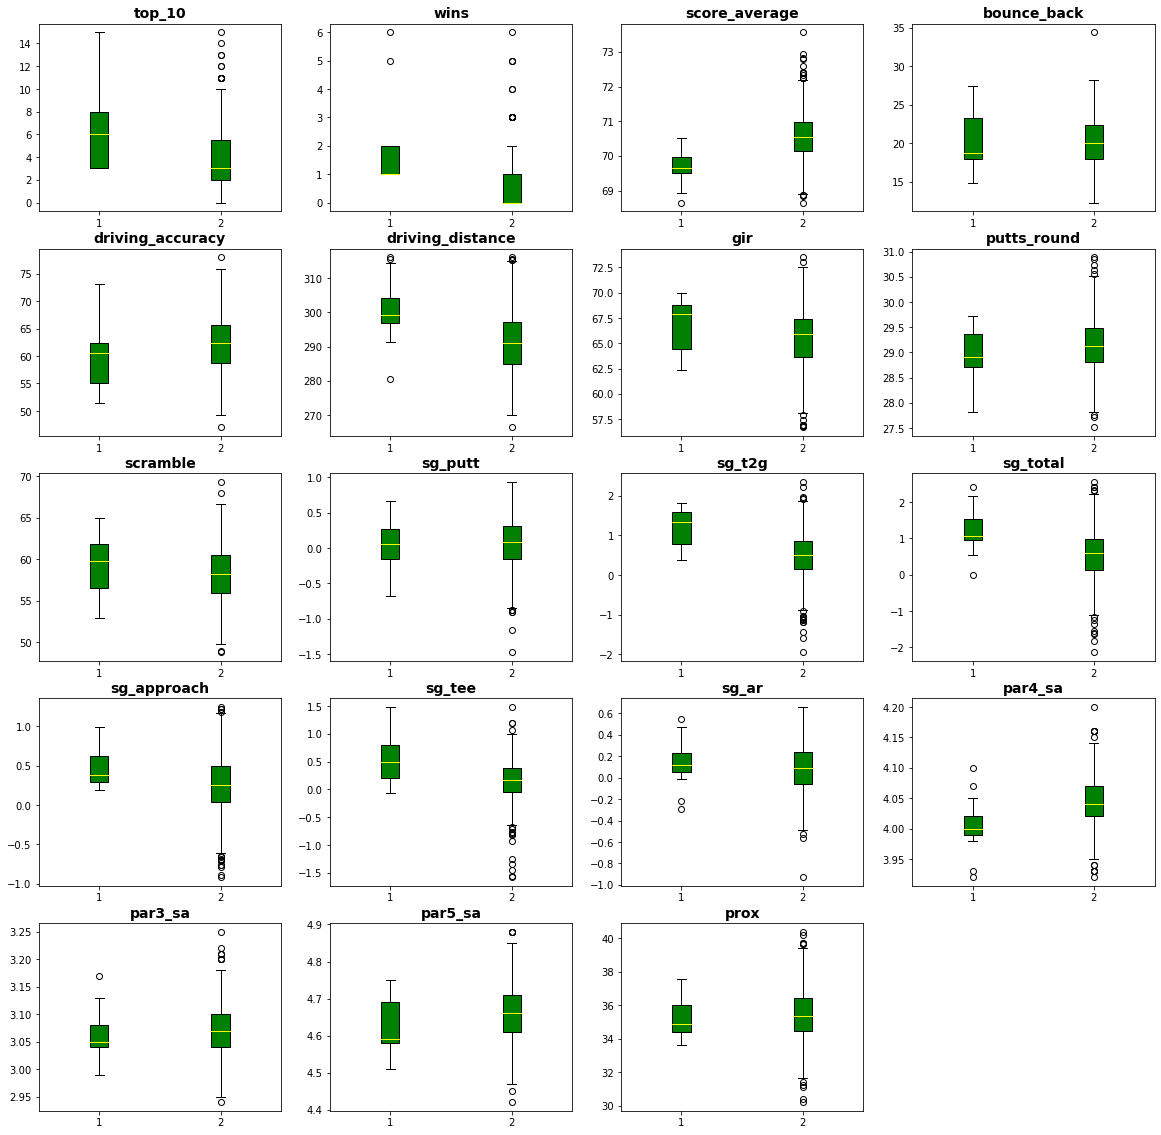

In [935]:
#Plot Boxplots of Winners vs the field for each predictor
plt.figure(figsize=(20,20))

for i in range(0, len(predictors)):
    plt.subplot(5,4,i+1)
    plt.gca().set_title(predictors[i], fontsize=14, fontweight='bold')
    x = master_winners.iloc[:,i]
    y = rest.iloc[:,i]
    x_y = [x,y]
    plt.boxplot(x_y, patch_artist=True, medianprops = dict(color = 'yellow'), boxprops = dict(facecolor = 'green'))
    
plt.savefig('box.png')

Predictors that jump out from this analysis: 
- score average
- driving distance
- sg tee to green
- sg total
- sg approach
- sg off the tee

In [936]:
#Define function to determine winners
def winner(x):
    if x == 1:
        win = 1
    else:
        win = 0
    return win

#Apply function
data['masters_win'] = data['masters_finish'].apply(winner)

In [937]:
#Create Plotly Parallel Coordinates Plot
par_data1 = data.iloc[:,5:15]
par_data2 = data.iloc[:,15:]
par_data2 = par_data2.drop(['masters_finish', 'masters_t10'], axis = 1)

par_data1 = par_data1.drop('rounds', axis = 1)

win = par_data2['masters_win'].tolist()
par_data1 = par_data1.assign(masters_win = win)

fig = px.parallel_coordinates(par_data1, color="masters_win",
                             color_continuous_scale=px.colors.diverging.RdYlGn,
                             color_continuous_midpoint=1)
fig.show()

In [998]:
fig = px.parallel_coordinates(par_data2, color="masters_win",
                             color_continuous_scale=px.colors.diverging.RdYlGn,
                             color_continuous_midpoint=1)
fig.show()

## Unbalanced Data

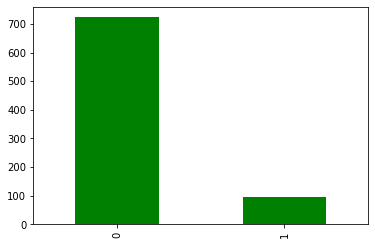

In [744]:
plt = data['masters_t10'].value_counts().plot(kind='bar', color = 'green')

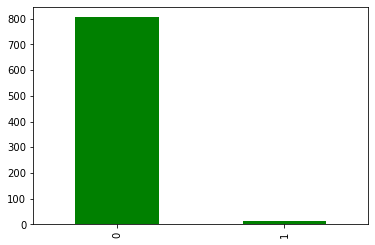

In [745]:
plt = data['masters_win'].value_counts().plot(kind='bar', color = 'green')

## Feature Selection

Did not do RFE because it tries to improve accuracy, which is not a good measure here

### Random Forest Feature Importance

In [941]:
predictors.remove('top_10')
predictors.remove('wins')

In [942]:
X = data[predictors]
y = data['masters_win']
    
#SMOTE and Random Undersampling
over = SMOTE(sampling_strategy=0.1, k_neighbors = 3)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_train, y_train = pipeline.fit_resample(X, y)
    
#Run Model
randomforest = RandomForestClassifier()
model = randomforest.fit(X_train, y_train)

pd.DataFrame(list(zip(X.columns,model.feature_importances_)), columns = ['predictor','feature importance'])

,predictor,feature importance
0,score_average,0.181204
1,bounce_back,0.041219
2,driving_accuracy,0.082599
3,driving_distance,0.093306
4,gir,0.056978
5,putts_round,0.030374
6,scramble,0.026101
7,sg_putt,0.026161
8,sg_t2g,0.098192
9,sg_total,0.087624


### Lasso Feature Selection

In [943]:
X = data[predictors]
y = data['masters_win']

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

#SMOTE and Random Undersampling
over = SMOTE(sampling_strategy=0.1, k_neighbors = 3)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_train, y_train = pipeline.fit_resample(X_std, y)

model = Lasso(alpha = 0.001)
model.fit(X_train, y_train)

pd.DataFrame(list(zip(X.columns,model.coef_)), columns = ['predictor','coefficient'])


/Users/samgreene/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009956136094681156, tolerance: 0.004



,predictor,coefficient
0,score_average,-0.400417
1,bounce_back,-0.146490
2,driving_accuracy,-0.021848
3,driving_distance,0.047968
4,gir,0.156897
5,putts_round,-0.367186
6,scramble,-0.057630
7,sg_putt,-0.183315
8,sg_t2g,0.000000
9,sg_total,-0.207136


# Preliminary Model Testing

Going to see if we can predict top 10 first

In [944]:
#Split Data
pred_data.drop('masters_finish', axis = 1)
training = data.loc[data['year'] <= 2017]
test = data.loc[data['year'] > 2017]
X_train = training[predictors]
y_train = training['masters_t10']
X_test = test[predictors]
y_test = test['masters_t10']

#Build Random Forest Model
randomforest = RandomForestClassifier()
model = randomforest.fit(X_train, y_train)

y_test_pred = model.predict(X_test)

In [946]:
#Show Results
print('precision:', metrics.precision_score(y_test, y_test_pred))
print('recall:', metrics.recall_score(y_test, y_test_pred))
print('f1:', metrics.f1_score(y_test, y_test_pred))
print('accuracy:', metrics.accuracy_score(y_test, y_test_pred))
print(pd.DataFrame(metrics.confusion_matrix(y_test, y_test_pred, labels = [0,1]), index = ['true:0', 'true:1'], columns = ['pred:0', 'pred:1']))

precision: 0.0
recall: 0.0
f1: 0.0
accuracy: 0.8608695652173913
        pred:0  pred:1
true:0      99       0
true:1      16       0


/Users/samgreene/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



We can see that there is a need for SMOTE and Random Undersampling because of the unbalanced data

## Using Smote and Random Undersampling

In [948]:
#Split Data
training = data.loc[data['year'] <= 2017]
test = data.loc[data['year'] > 2017]
X_train = training[predictors]
y_train = training['masters_t10']
X_test = test[predictors]
y_test = test['masters_t10']

#SMOTE
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

#Build Model
X_train, y_train = pipeline.fit_resample(X_train, y_train)

randomforest = RandomForestClassifier()
model = randomforest.fit(X_train, y_train)

y_test_pred = model.predict(X_test)

In [949]:
#Print Results
print('precision:', metrics.precision_score(y_test, y_test_pred))
print('recall:', metrics.recall_score(y_test, y_test_pred))
print('f1:', metrics.f1_score(y_test, y_test_pred))
print('accuracy:', metrics.accuracy_score(y_test, y_test_pred))
print(pd.DataFrame(metrics.confusion_matrix(y_test, y_test_pred, labels = [0,1]), index = ['true:0', 'true:1'], columns = ['pred:0', 'pred:1']))

precision: 0.3181818181818182
recall: 0.4375
f1: 0.3684210526315789
accuracy: 0.7913043478260869
        pred:0  pred:1
true:0      84      15
true:1       9       7


# Predicting Winners

## Random Forest Technical LOOCV

I removed 2019 because Tiger Woods was an outlier as he did not play many other tournaments that year, and 2016 because driving distance on the PGA tour site is not scrapable for that year

In [950]:
years = [2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2017,2018]

In [951]:
precision = []
recall = []
f1 = []
accuracy = []
pred_winners = []

for x in range(1,21):
    for year in years:
        #Split Data
        training = data.loc[data['year'] != year]
        test = data.loc[data['year'] == year]
        X_train = training[predictors]
        y_train = training['masters_win']
        X_test = test[predictors]
        y_test = test['masters_win']
    
        #SMOTE and Random Undersampling
        over = SMOTE(sampling_strategy=0.1, k_neighbors = 3)
        under = RandomUnderSampler(sampling_strategy=0.5)
        steps = [('o', over), ('u', under)]
        pipeline = Pipeline(steps=steps)
        X_train, y_train = pipeline.fit_resample(X_train, y_train)
    
        #Run Model
        randomforest = RandomForestClassifier()
        model = randomforest.fit(X_train, y_train)

        y_test_pred = model.predict(X_test)
        y_test_pred_proba = model.predict_proba(X_test)
    
        #Get Metrics
        pre = metrics.precision_score(y_test, y_test_pred)
        rec = metrics.recall_score(y_test, y_test_pred)
        f = metrics.f1_score(y_test, y_test_pred)
        acc = metrics.accuracy_score(y_test, y_test_pred)
    
        precision.append(pre)
        recall.append(rec)
        f1.append(f)
        accuracy.append(acc)
    
        my_list = y_test_pred.tolist()
        indices = [i for i, x in enumerate(my_list) if x == 1]
        
        pred_winners.append(len(indices))

/Users/samgreene/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/samgreene/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/samgreene/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/samgreene/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter

In [952]:
#Show Results
print('precision:', np.mean(precision))
print('recall:', np.mean(recall))
print('f1:', np.mean(f1))
print('accuracy:', np.mean(accuracy))

precision: 0.07711080586080586
recall: 0.21153846153846154
f1: 0.10697191697191696
accuracy: 0.9502102606135856


## SVM Linear Technical LOOCV

In [953]:
years = [2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2017,2018]

In [956]:
precision = []
recall = []
f1 = []
accuracy = []
pred_winners = []


for x in range(1,21):
    for year in years:
        #Split Data
        training = data.loc[data['year'] != year]
        test = data.loc[data['year'] == year]
        X_train = training[predictors]
        y_train = training['masters_win']
        X_test = test[predictors]
        y_test = test['masters_win']
    
        #Standardize Predictors and Test
        scaler = StandardScaler()
        X_train_std = scaler.fit_transform(X_train)
        X_test_std = scaler.fit_transform(X_test)
    
        #SMOTE and Random Undersampling
        over = SMOTE(sampling_strategy=0.1, k_neighbors = 3)
        under = RandomUnderSampler(sampling_strategy=0.5)
        steps = [('o', over), ('u', under)]
        pipeline = Pipeline(steps=steps)
        X_train_std, y_train = pipeline.fit_resample(X_train_std, y_train)
    
        #Run Model
        svc = SVC(kernel = 'linear', )
        model = svc.fit(X_train_std, y_train)

        y_test_pred = model.predict(X_test_std)
        #Get Metrics
        pre = metrics.precision_score(y_test, y_test_pred)
        rec = metrics.recall_score(y_test, y_test_pred)
        f = metrics.f1_score(y_test, y_test_pred)
        acc = metrics.accuracy_score(y_test, y_test_pred)
    
        precision.append(pre)
        recall.append(rec)
        f1.append(f)
        
        accuracy.append(acc)
        
        my_list = y_test_pred.tolist()
        indices = [i for i, x in enumerate(my_list) if x == 1]
        
        pred_winners.append(len(indices))

In [957]:
#Show Results
print('precision:', np.mean(precision))
print('recall:', np.mean(recall))
print('f1:', np.mean(f1))
print('accuracy:', np.mean(accuracy))

precision: 0.08147324897324897
recall: 0.5115384615384615
f1: 0.13907340522725137
accuracy: 0.8926858856253205


## SVM RBF Technical LOOCV

In [961]:
precision = []
recall = []
f1 = []
accuracy = []

for x in range(1,21):
    for year in years:
        #Split Data
        training = data.loc[data['year'] != year]
        test = data.loc[data['year'] == year]
        X_train = training[predictors]
        y_train = training['masters_win']
        X_test = test[predictors]
        y_test = test['masters_win']

        #Standardize Predictors and Test
        scaler = StandardScaler()
        X_train_std = scaler.fit_transform(X_train)
        X_test_std = scaler.fit_transform(X_test)

        #SMOTE and Random Undersampling
        over = SMOTE(sampling_strategy=0.1, k_neighbors = 3)
        under = RandomUnderSampler(sampling_strategy=0.5)
        steps = [('o', over), ('u', under)]
        pipeline = Pipeline(steps=steps)
        X_train_std, y_train = pipeline.fit_resample(X_train_std, y_train)

        #Run Model
        svc = SVC(kernel = 'rbf')
        model = svc.fit(X_train_std, y_train)

        y_test_pred = model.predict(X_test_std)
        #Get Metrics
        pre = metrics.precision_score(y_test, y_test_pred)
        rec = metrics.recall_score(y_test, y_test_pred)
        f = metrics.f1_score(y_test, y_test_pred)
        acc = metrics.accuracy_score(y_test, y_test_pred)

        precision.append(pre)
        recall.append(rec)
        f1.append(f)

        accuracy.append(acc)

        my_list = y_test_pred.tolist()
        indices = [i for i, x in enumerate(my_list) if x == 1]

        pred_winners.append(len(indices))

/Users/samgreene/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/samgreene/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/samgreene/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/samgreene/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter

In [963]:
#Show Results
print('precision:', np.mean(precision))
print('recall:', np.mean(recall))
print('f1:', np.mean(f1))
print('accuracy:', np.mean(accuracy))

precision: 0.06807234432234432
recall: 0.2692307692307692
f1: 0.1045115995115995
accuracy: 0.9211300029373191


## Hyper Parameter Tuning

I conducted some hyperparameter tuning however, it did not have much effect on model performance

In [964]:
X = data[predictors]
y = data['masters_win']

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

X_train, X_test , y_train , y_test = train_test_split(X_std, y, test_size = 0.3, random_state = 5)

over = SMOTE(sampling_strategy=0.5, k_neighbors = 3)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_train, y_train = pipeline.fit_resample(X_train, y_train)

In [1428]:
# defining parameter range 
param_grid = {'C': [0.1, 0.2, 0.5, 1],  
              'gamma': [5, 4, 3, 2], 
              'kernel': ['rbf', 'linear']}

grid = GridSearchCV(SVC(), param_grid, refit = True, scoring = 'f1', verbose = True) 

# fitting the model for grid search 
grid.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    2.2s finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 0.2, 0.5, 1], 'gamma': [5, 4, 3, 2],
                         'kernel': ['rbf', 'linear']},
             scoring='f1', verbose=True)

In [1429]:
print(grid.best_params_)

{'C': 1, 'gamma': 2, 'kernel': 'rbf'}


# Predict 2020 Winner

In [967]:
#Split Data
training = data
test = data2020
X_train = training[predictors]
y_train = training['masters_win']
X_test = test[predictors]

#Standardize Predictors
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

#SMOTE and Undersampling
over = SMOTE(sampling_strategy=0.1, k_neighbors = 3)
under = RandomUnderSampler(sampling_strategy=0.5)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train_mod, y_train_mod = pipeline.fit_resample(X_train_std, y_train)

#Fit Model
svc = SVC(kernel = 'linear', probability = True)
model = svc.fit(X_train_mod, y_train_mod)

y_pred = model.predict(X_test_std)
y_pred_proba = model.predict_proba(X_test_std)

#Add Predictions to DF
data2020['masters_prediction'] = y_pred.tolist()



In [969]:
#Show player with highest predicted probability
probs = []
for i in range(0, len(y_pred_proba)):
    prob = y_pred_proba[i,1]
    probs.append(prob)
    
data2020['prob'] = probs

index = probs.index(np.max(probs))
loc = X_test.iloc[index,:]['score_average']
data2020.loc[data2020['score_average'] == loc]

,year,player_name,ranking,top_10,wins,score_average,rounds,bounce_back,driving_accuracy,driving_distance,...,sg_approach,sg_tee,sg_ar,par4_sa,par3_sa,masters_finish,par5_sa,prox,masters_prediction,prob
54,2020,Rory McIlroy,16,7,1,69.219,60.0,19.73,56.34,314.0,...,0.504,0.702,0.108,3.96,3.01,NaN,4.54,36.874495,1,0.988586


In [970]:
winners = data2020.loc[data2020['masters_prediction'] == 1]
winners

,year,player_name,ranking,top_10,wins,score_average,rounds,bounce_back,driving_accuracy,driving_distance,...,sg_approach,sg_tee,sg_ar,par4_sa,par3_sa,masters_finish,par5_sa,prox,masters_prediction,prob
34,2020,Justin Thomas,6,10,3,69.128,66.0,26.95,57.25,304.2,...,0.997,0.405,0.339,3.93,3.04,NaN,4.48,34.228966,1,0.644557
49,2020,Patrick Reed,22,8,1,69.586,74.0,22.03,56.08,296.0,...,0.102,0.278,0.316,3.95,3.08,NaN,4.57,37.057593,1,0.786855
54,2020,Rory McIlroy,16,7,1,69.219,60.0,19.73,56.34,314.0,...,0.504,0.702,0.108,3.96,3.01,NaN,4.54,36.874495,1,0.988586
55,2020,Scottie Scheffler,8,7,0,69.709,82.0,22.34,61.24,308.9,...,0.398,0.618,0.115,3.95,3.04,NaN,4.55,34.817975,1,0.641534
56,2020,Sergio Garcia,T76,1,0,70.574,44.0,24.79,60.62,305.8,...,0.181,0.848,0.308,3.98,3.13,NaN,4.64,35.644629,1,0.470014
62,2020,Tony Finau,21,7,0,69.992,72.0,22.73,51.79,309.8,...,0.497,0.341,0.266,3.97,3.04,NaN,4.56,35.305714,1,0.466554


## Unstable Data, Run Model 100 times (2020) 

In [974]:
dubs = []

for i in range(0,1000):
    #Split Data
    training = data
    test = data2020
    X_train = training[predictors]
    y_train = training['masters_win']
    X_test = test[predictors]

    
    #Standardize Predictors
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.fit_transform(X_test)
    
    #SMOTE and Undersampling
    over = SMOTE(sampling_strategy=0.1, k_neighbors = 3)
    under = RandomUnderSampler(sampling_strategy=0.5)

    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)

    X_train_mod, y_train_mod = pipeline.fit_resample(X_train_std, y_train)
    
    #Train Model
    svc = SVC(kernel = 'linear', probability = True)
    model = svc.fit(X_train_mod, y_train_mod)

    y_pred = model.predict(X_test_std)
    y_pred_proba = model.predict_proba(X_test_std)

    #Add Predictions to DF
    data2020['masters_prediction'] = y_pred.tolist()

    probs = []
    for i in range(0, len(y_pred_proba)):
        prob = y_pred_proba[i,1]
        probs.append(prob)

    data2020['prob'] = probs

    winners = data2020['player_name'].loc[data2020['masters_prediction'] == 1].to_list()
    dubs.append(winners)

In [975]:
#Format Results
flat_list = []
for sublist in dubs:
    for item in sublist:
        flat_list.append(item)
        
results = Counter(flat_list)

collections.OrderedDict(sorted(results.items(), reverse=True, key=lambda t: t[1]))

OrderedDict([('Rory McIlroy', 1000),
             ('Patrick Reed', 985),
             ('Scottie Scheffler', 979),
             ('Justin Thomas', 859),
             ('Tony Finau', 596),
             ('Bryson DeChambeau', 585),
             ('Bubba Watson', 404),
             ('Sergio Garcia', 329),
             ('Hideki Matsuyama', 268),
             ('Tommy Fleetwood', 242),
             ('Byeong Hun An', 201),
             ('Webb Simpson', 135),
             ('Xander Schauffele', 94),
             ('Si Woo Kim', 67),
             ('Dustin Johnson', 67),
             ('Adam Scott', 46),
             ('Collin Morikawa', 34),
             ('Tyrrell Hatton', 16),
             ('Jon Rahm', 8),
             ('Louis Oosthuizen', 8),
             ('Patrick Cantlay', 6),
             ('Paul Casey', 6),
             ('Brooks Koepka', 4),
             ('Jason Day', 4),
             ('Joaquin Niemann', 4),
             ('Sungjae Im', 3),
             ('Lucas Glover', 3),
             ('Marc Leish

## Run with 2021 Data

In [976]:
dubs = []

for i in range(0,1000):
    #Split Data
    training = data
    test = data2021
    X_train = training[predictors]
    y_train = training['masters_win']
    X_test = test[predictors]

    
    #Standardize Predictors
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.fit_transform(X_test)
    
    #SMOTE and Undersampling
    over = SMOTE(sampling_strategy=0.1, k_neighbors = 3)
    under = RandomUnderSampler(sampling_strategy=0.5)

    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)

    X_train_mod, y_train_mod = pipeline.fit_resample(X_train_std, y_train)
    
    #Train Model
    svc = SVC(kernel = 'linear', probability = True)
    model = svc.fit(X_train_mod, y_train_mod)

    y_pred = model.predict(X_test_std)
    y_pred_proba = model.predict_proba(X_test_std)

    #Add Predictions to DF
    data2021['masters_prediction'] = y_pred.tolist()

    probs = []
    for i in range(0, len(y_pred_proba)):
        prob = y_pred_proba[i,1]
        probs.append(prob)

    data2021['prob'] = probs

    winners = data2021['player_name'].loc[data2021['masters_prediction'] == 1].to_list()
    dubs.append(winners)

In [977]:
#Format Results
flat_list = []
for sublist in dubs:
    for item in sublist:
        flat_list.append(item)
        
results = Counter(flat_list)

collections.OrderedDict(sorted(results.items(), reverse=True, key=lambda t: t[1]))

OrderedDict([('Dustin Johnson', 1000),
             ('Brooks Koepka', 996),
             ('Hideki Matsuyama', 979),
             ('Tyrrell Hatton', 942),
             ('Justin Thomas', 920),
             ('Jon Rahm', 905),
             ('Rory McIlroy', 844),
             ('Matthew Wolff', 778),
             ('Lee Westwood', 747),
             ('Xander Schauffele', 729),
             ('Adam Scott', 591),
             ('Bryson DeChambeau', 518),
             ('Jason Kokrak', 258),
             ('Rickie Fowler', 165),
             ('Tony Finau', 94),
             ('Joaquin Niemann', 92),
             ('Patrick Reed', 82),
             ('Cameron Champ', 67),
             ('Byeong Hun An', 33),
             ('Louis Oosthuizen', 31),
             ('Sergio Garcia', 21),
             ('Matthew Fitzpatrick', 18),
             ('Sungjae Im', 17),
             ('Lucas Glover', 13),
             ('Danny Willett', 10),
             ('Jimmy Walker', 10),
             ('Jordan Spieth', 8),
          

# Cost Benefit Analysis

In [978]:
#JT: 12-1
#PR: 30-1
#RM: 13-1
#SS: 60-1
#TF: 30-1

recall = 0.5115384615384615

#Odds at the beginning of Masters week
multiplier = [12, 30, 13, 60, 30]

#$20 on each predicted winner
bet = 20
winnings = []

for x in multiplier:
    w = bet*x
    winnings.append(w)

avg_winnings = np.mean(winnings)

EV = ((avg_winnings * recall) - (bet*len(multiplier))) + ((-bet*len(multiplier)) * (1-recall))

In [979]:
#Print EV
EV

147.8461538461538

# Analyze Predicted Winners

In [994]:
#Filter for predicted winners
winners = data2020.loc[data2020['player_name'].isin(['Justin Thomas', 'Rory McIlroy', 'Scottie Scheffler',
                                                     'Patrick Reed', 'Tony Finau'])]

#Drop unnecessary columns
winners = winners.drop('rounds', axis = 1)
winners = winners.drop('x_of_attempts', axis = 1)
winners = winners.drop('masters_finish', axis = 1)
winners = winners.drop('hole_proximity', axis = 1)

#Create Dataframe to compare stats
field = []
jt = []
pr = []
rm = []
ss = []
tf = []



for i in range(0,len(predictors)):
    jt.append(winners.iloc[0,i+5])
    pr.append(winners.iloc[1,i+5])
    rm.append(winners.iloc[2,i+5])
    ss.append(winners.iloc[3,i+5])
    tf.append(winners.iloc[4,i+5])

for pred in predictors:
    field.append(np.mean(data2020[pred]))
    
df = pd.DataFrame({'stat': predictors,
                   'Justin Thomas': jt,
                  'Patrick Reed': pr,
                  'Rory McIlroy': rm,
                  'Scottie Scheffler': ss,
                  'Tony Finau': tf,
                  'Field': field})

df = df.T
df.columns = df.iloc[0]
df = df.iloc[1:]

df

stat,score_average,bounce_back,driving_accuracy,driving_distance,gir,putts_round,scramble,sg_putt,sg_t2g,sg_total,sg_approach,sg_tee,sg_ar,par4_sa,par3_sa,par5_sa,prox
Justin Thomas,69.128,26.95,57.25,304.2,69.61,28.62,63.16,-0.031,1.741,1.709,0.997,0.405,0.339,3.93,3.04,4.48,34.229
Patrick Reed,69.586,22.03,56.08,296,65.32,27.89,63.64,0.599,0.696,1.295,0.102,0.278,0.316,3.95,3.08,4.57,37.0576
Rory McIlroy,69.219,19.73,56.34,314,67.78,28.57,60.63,-0.071,1.314,1.243,0.504,0.702,0.108,3.96,3.01,4.54,36.8745
Scottie Scheffler,69.709,22.34,61.24,308.9,69.04,28.71,60.61,-0.053,1.131,1.078,0.398,0.618,0.115,3.95,3.04,4.55,34.818
Tony Finau,69.992,22.73,51.79,309.8,68.83,28.57,60.89,0.14,1.103,1.243,0.497,0.341,0.266,3.97,3.04,4.56,35.3057
Field,70.4511,21.6179,60.0538,299.196,66.6081,28.7991,59.7128,0.0997059,0.388,0.487632,0.177735,0.159426,0.05075,4.00368,3.04985,4.62147,36.1318


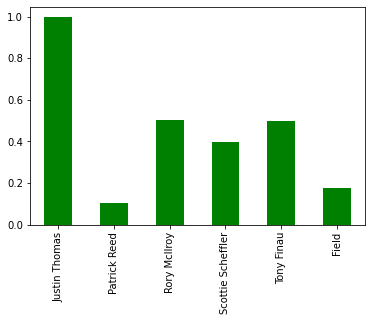

In [995]:
plt = df['sg_approach'].plot(kind='bar', color = 'green')

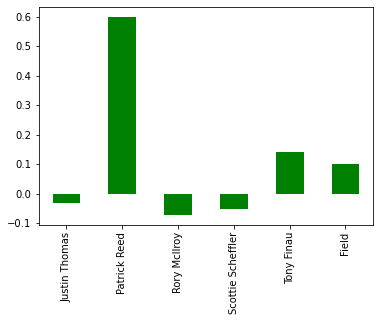

In [996]:
plt = df['sg_putt'].plot(kind='bar', color = 'green')

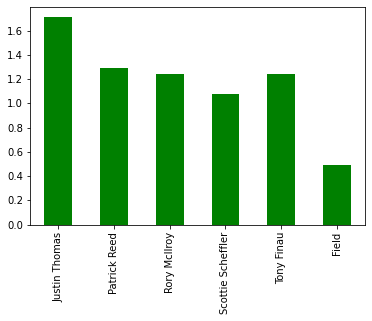

In [997]:
plt = df['sg_total'].plot(kind='bar', color = 'green')